In [ ]:
# !pip install -q tensorflow
# !pip install -q keras
# !pip install -q numpy
# !pip install -q pandas
# !pip install -q matplotlib
# !pip install -q seaborn
# !pip install opencv-python

In [3]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pickle
import gc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from PIL import Image, UnidentifiedImageError, ImageEnhance


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = os.getcwd().replace("notebooks", "") ## Local path directory
# gcolb_path = {
#     "glioma": "/content/drive/MyDrive/UNDB_INTELIGÊNCIA ARTIFICIAL_PBL2/data/external/BrainCancer/brain_glioma",
#     "meningioma": "/content/drive/MyDrive/UNDB_INTELIGÊNCIA ARTIFICIAL_PBL2/data/external/BrainCancer/brain_menin",
#     "tumor": "/content/drive/MyDrive/UNDB_INTELIGÊNCIA ARTIFICIAL_PBL2/data/external/BrainCancer/brain_tumor"
# }

In [5]:
glioma = {
    'category_name': 'glioma',
    'load_command': [fr'{path + r"data\external\BrainCancer\brain_glioma"}\{i}' for i in os.listdir(path + r"data\external\BrainCancer\brain_glioma")] #Local command
    # 'load_command': [f"{gcolb_path['glioma']}" + "/" + f'{i}' for i in os.listdir(gcolb_path['glioma'])]
}

meningioma = {
    'category_name': 'meningioma',
    'load_command': [fr'{path + r"data\external\BrainCancer\brain_menin"}\{i}' for i in os.listdir(path + r"data\external\BrainCancer\brain_menin")] #Local command
    # 'load_command': [f"{gcolb_path['meningioma']}" + "/" + f'{i}' for i in os.listdir(gcolb_path['meningioma'])]
}

tumor = {
    'category_name': 'tumor',
    'load_command': [fr'{path + r"data\external\BrainCancer\brain_tumor"}\{i}' for i in os.listdir(path + r"data\external\BrainCancer\brain_tumor")] #Local command
    # 'load_command': [f"{gcolb_path['tumor']}" + "/" + f'{i}' for i in os.listdir(gcolb_path['tumor'])]
}

categories = [glioma, meningioma, tumor]

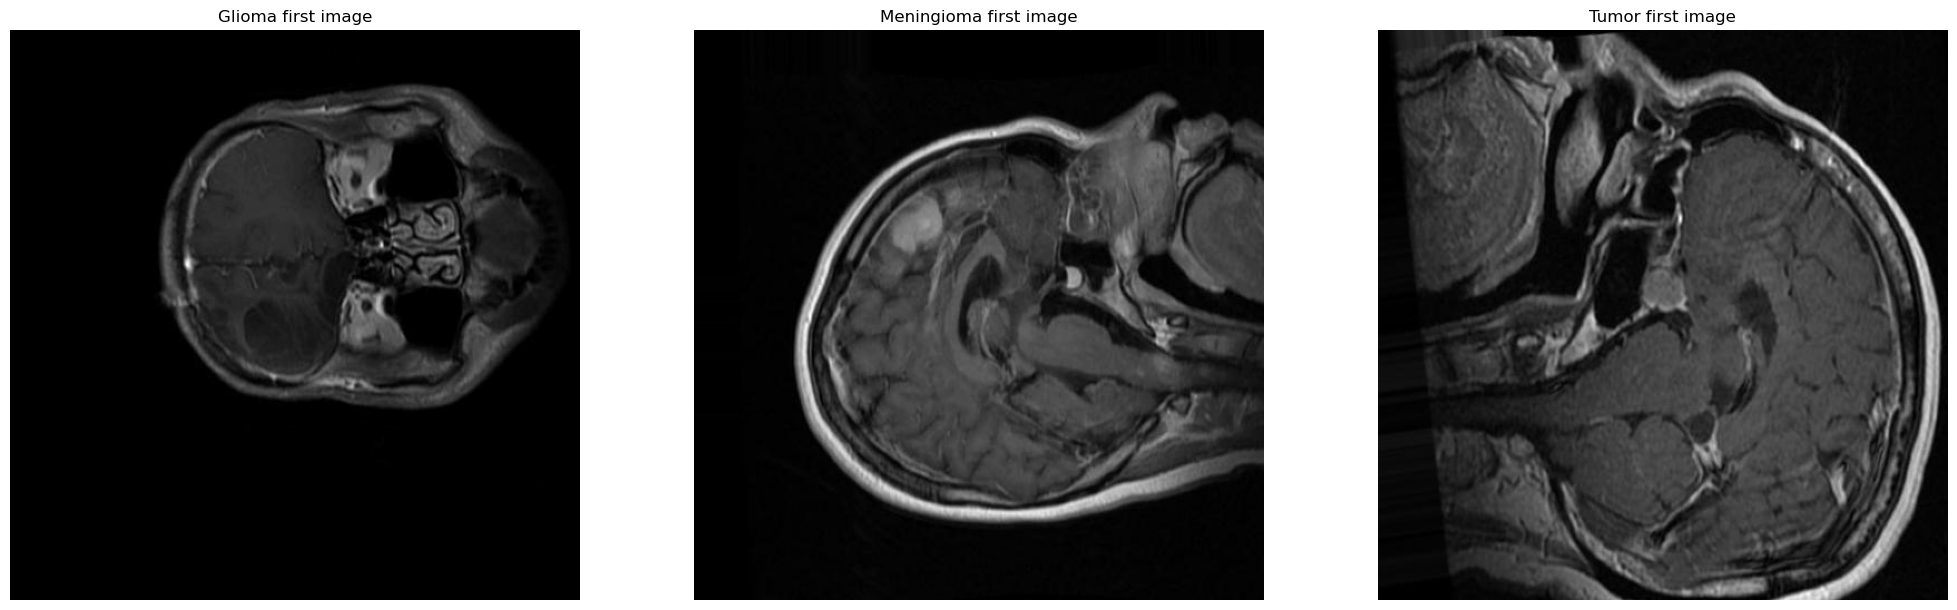



Size of the image
Category: glioma
(512, 512)


Size of the image
Category: meningioma
(512, 512)


Size of the image
Category: tumor
(512, 512)


In [6]:
img1 = Image.open(f"{glioma['load_command'][0]}")
img2 = Image.open(f"{meningioma['load_command'][0]}")
img3 = Image.open(f"{tumor['load_command'][0]}")

plt.figure(figsize=(25, 10))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow([img1, img2, img3][i])
    plt.title(["Glioma first image", "Meningioma first image", "Tumor first image"][i])
    plt.axis("off")
plt.show()

for size,name in zip([img1.size, img2.size, img3.size],categories):
    print('\n')
    print(f"Size of the image\nCategory: {name['category_name']}")
    print(size)

In [12]:
class ImageDataGenerator:
    @staticmethod
    def reshape_image(image):
        if isinstance(image, str):  # If the input is a file path
            with Image.open(image) as img:  # Use 'with' to ensure proper closure
                img = img.resize((299, 299))  # Resize to the desired shape
                img_array = np.asarray(img, dtype=np.uint8)  # Convert to NumPy array with uint8
        elif isinstance(image, np.ndarray):  # If the input is a NumPy array
            if image.dtype != np.uint8:
                image = (image * 255).astype(np.uint8)  # Convert float32 to uint8
            if image.ndim == 2:  # If grayscale, add a channel dimension
                image = np.expand_dims(image, axis=-1)
            img = Image.fromarray(image)
            img = img.resize((299, 299))  # Resize to the desired shape
            img_array = np.asarray(img, dtype=np.uint8)  # Convert back to NumPy array if needed
        else:
            raise ValueError("Input must be a file path (str) or a NumPy array.")

        # Clear the img variable to free up memory
        del img

        return img_array

    @staticmethod
    def modify_images(image, list_size=5):
        # For now, return the original image wrapped in a list
        return [image]  # Placeholder for the existing modify_images logic

    @staticmethod
    def split_data(X, y, test_size=0.4):
        return train_test_split(X, y, test_size=test_size, random_state=42)

    @staticmethod
    def load_images(categories, batch_size=25):
        all_X_train_augmented = []
        all_y_train_augmented = []
        all_X = []
        all_y = []
        X_val = []
        y_val = []

        # Create a mapping from category names to integer labels
        category_to_label = {category['category_name']: idx for idx, category in enumerate(categories)}

        for category_dict in categories:
            X, y = [], []
            load_command = category_dict['load_command']
            category_name = category_dict['category_name']

            for file_path in load_command:
                img = ImageDataGenerator.reshape_image(file_path)
                X.append(img)
                y.append(category_to_label[category_name])  # Use integer label

                # Process in batches
                if len(X) >= batch_size:
                    X_train, X_test, y_train, y_test = ImageDataGenerator.split_data(X, y)
                    # Augment data in batches
                    X_train_augmented, y_train_augmented = [], []
                    for i in range(len(X_train)):
                        original_image = Image.fromarray(X_train[i])  # Convert back to PIL Image
                        images = ImageDataGenerator.modify_images(original_image)
                        X_train_augmented.extend([np.asarray(img, dtype=np.float32) for img in images])  # Convert back to array in one go
                        y_train_augmented.extend([y_train[i]] * len(images))  # Extend labels accordingly

                        # Clear memory
                        del original_image, images
                        gc.collect()

                    # Reshape images
                    X_train_augmented = [ImageDataGenerator.reshape_image(img) for img in X_train_augmented]

                    # Store augmented data
                    all_X_train_augmented.extend(X_train_augmented)
                    all_y_train_augmented.extend(y_train_augmented)

                    # Clear the lists for the next batch
                    X, y = [], []

            # Process any remaining images after the loop
            if X:
                X_train, X_test, y_train, y_test = ImageDataGenerator.split_data(X, y)
                X_train_augmented, y_train_augmented = [], []
                for i in range(len(X_train)):
                    original_image = Image.fromarray(X_train[i])  # Convert back to PIL Image
                    images = ImageDataGenerator.modify_images(original_image)
                    X_train_augmented.extend([np.asarray(img, dtype=np.float32) for img in images])  # Convert back to array in one go
                    y_train_augmented.extend([y_train[i]] * len(images))  # Extend labels accordingly

                    # Clear memory
                    del original_image, images
                    gc.collect()

                # Reshape images
                X_train_augmented = [ImageDataGenerator.reshape_image(img) for img in X_train_augmented]
                y_train_augmented = to_categorical(y_train_augmented)

                # Store augmented data
                all_X_train_augmented.extend(X_train_augmented)
                all_y_train_augmented.extend(y_train_augmented)
        
        X_train_augmented, X_val, y_train_augmented, y_val = ImageDataGenerator.split_data(all_X_train_augmented, all_y_train_augmented, test_size=0.5)
        
        # Return all collected data at the end
        return all_X, all_y, np.asarray(X_train_augmented), np.asarray(X_test), np.asarray(to_categorical(y_train_augmented)), np.asarray(to_categorical(y_test)), np.asarray(X_val), np.asarray(y_val)

In [8]:
def save_variables(variables, filename):
  with open(filename, 'wb') as file:
      pickle.dump(variables, file)
  print(f"Variables saved to {filename}.")

In [13]:
X, y, X_train, X_test, y_train, y_test, X_val, y_val = ImageDataGenerator.load_images(categories)

variables_to_save = {
    'X_train': X_train,
    'y_train': y_train,
    'X_test': X_test,
    'y_test': y_test,
    'X_val': X_val,
    'y_val': y_val
}

# Save the variables to a file
save_variables(variables_to_save, 'saved_variables.pkl')

KeyboardInterrupt: 